In [2]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

100%|██████████| 9912422/9912422 [00:04<00:00, 2119308.76it/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1459304.04it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [4]:
len(dataset)

60000

In [5]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [6]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


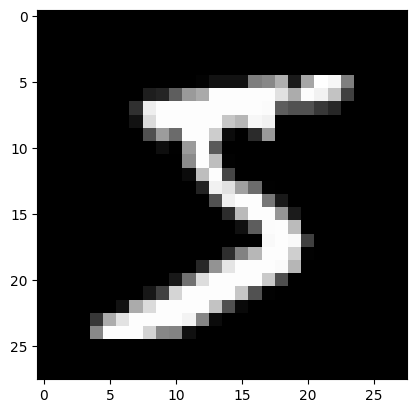

In [8]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


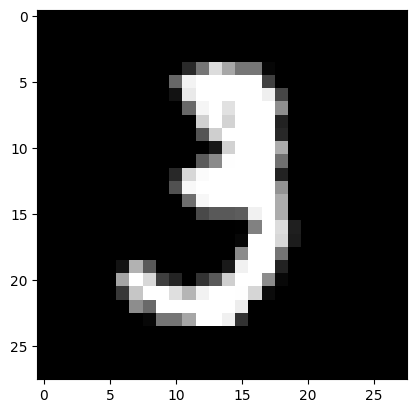

In [9]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [10]:
import torchvision.transforms as transforms

In [11]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


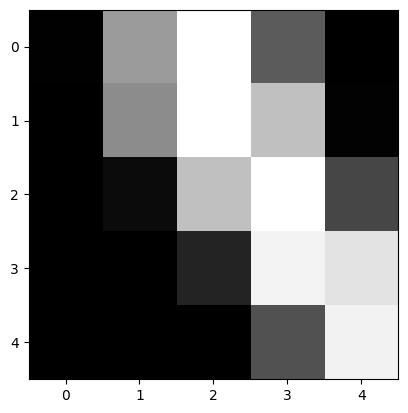

In [14]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

In [15]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [16]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model. 

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [18]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [19]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0203, -0.0183,  0.0253,  ...,  0.0245,  0.0303, -0.0261],
        [ 0.0287,  0.0184,  0.0061,  ...,  0.0307, -0.0093,  0.0056],
        [-0.0288, -0.0169, -0.0319,  ..., -0.0181, -0.0081, -0.0271],
        ...,
        [-0.0248, -0.0308,  0.0231,  ...,  0.0066, -0.0176, -0.0237],
        [ 0.0122, -0.0250,  0.0298,  ..., -0.0270, -0.0181,  0.0228],
        [-0.0025, -0.0172,  0.0003,  ...,  0.0003, -0.0229,  0.0233]],
       requires_grad=True)

In [20]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0064, -0.0056, -0.0132,  0.0075,  0.0068,  0.0242, -0.0260,  0.0179,
         0.0313, -0.0198], requires_grad=True)

In [21]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([4, 2, 2, 2, 2, 7, 0, 8, 3, 3, 2, 1, 2, 6, 5, 3, 3, 1, 2, 1, 5, 9, 3, 1,
        3, 8, 6, 4, 8, 1, 0, 6, 2, 9, 7, 5, 5, 2, 0, 0, 7, 5, 8, 1, 2, 2, 7, 6,
        7, 8, 1, 4, 3, 1, 2, 1, 8, 4, 8, 6, 6, 7, 3, 3, 3, 8, 7, 8, 5, 1, 9, 8,
        8, 5, 3, 0, 6, 0, 8, 5, 8, 3, 8, 0, 1, 2, 8, 9, 7, 8, 0, 1, 5, 9, 1, 1,
        9, 1, 1, 4, 3, 4, 8, 5, 7, 1, 0, 2, 0, 6, 8, 7, 9, 3, 2, 4, 9, 0, 9, 0,
        2, 9, 1, 6, 4, 4, 9, 0])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

In [22]:
images.shape

torch.Size([128, 1, 28, 28])

In [23]:
images.reshape(128, 784).shape

torch.Size([128, 784])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch. 

A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

In [24]:
class Person:
    # Class constructor
    def __init__(self, name, age):
        # Object properties
        self.name = name
        self.age = age
    
    # Method
    def say_hello(self):
        print("Hello my name is " + self.name + "!")

In [25]:
bob = Person("Bob", 32)

In [26]:
bob.say_hello()

Hello my name is Bob!


In [27]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

In [28]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [29]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0293,  0.0153,  0.0101,  ..., -0.0265,  0.0142,  0.0260],
         [ 0.0238,  0.0316,  0.0220,  ..., -0.0321,  0.0043,  0.0142],
         [-0.0326,  0.0336, -0.0157,  ..., -0.0166, -0.0273,  0.0047],
         ...,
         [ 0.0231, -0.0228, -0.0121,  ..., -0.0114, -0.0069,  0.0131],
         [ 0.0033,  0.0036,  0.0336,  ...,  0.0035, -0.0217,  0.0262],
         [ 0.0113,  0.0060, -0.0124,  ..., -0.0045,  0.0234,  0.0288]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0129,  0.0289,  0.0055, -0.0217,  0.0332,  0.0137, -0.0047, -0.0132,
         -0.0158,  0.0089], requires_grad=True)]

In [30]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0384,  0.0544, -0.1416,  0.0390,  0.2030,  0.1493,  0.0208, -0.0036,
         -0.0502, -0.0947],
        [ 0.0328,  0.0352, -0.0597, -0.3141,  0.0796, -0.0220,  0.2224,  0.0823,
         -0.1770,  0.0441]])


In [31]:
import torch.nn.functional as F

In [32]:
outputs[:2]

tensor([[-0.0384,  0.0544, -0.1416,  0.0390,  0.2030,  0.1493,  0.0208, -0.0036,
         -0.0502, -0.0947],
        [ 0.0328,  0.0352, -0.0597, -0.3141,  0.0796, -0.0220,  0.2224,  0.0823,
         -0.1770,  0.0441]], grad_fn=<SliceBackward0>)

In [33]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0944, 0.1036, 0.0852, 0.1020, 0.1202, 0.1139, 0.1002, 0.0978, 0.0933,
         0.0893],
        [0.1031, 0.1034, 0.0940, 0.0729, 0.1081, 0.0976, 0.1247, 0.1084, 0.0836,
         0.1043]])
Sum:  1.0


In [34]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([4, 6, 4, 6, 3, 4, 4, 2, 2, 9, 2, 2, 6, 2, 9, 9, 2, 9, 9, 7, 4, 4, 2, 2,
        9, 9, 1, 4, 9, 9, 2, 4, 2, 9, 2, 9, 2, 4, 2, 2, 9, 6, 9, 2, 2, 2, 7, 2,
        2, 2, 9, 9, 9, 5, 2, 7, 9, 9, 9, 9, 2, 9, 9, 9, 9, 2, 7, 9, 9, 4, 4, 2,
        2, 6, 7, 2, 2, 4, 2, 9, 2, 8, 2, 2, 9, 2, 1, 4, 9, 4, 9, 2, 2, 2, 6, 9,
        2, 6, 9, 7, 9, 2, 6, 4, 6, 4, 9, 4, 9, 9, 9, 9, 9, 9, 2, 2, 6, 9, 9, 2,
        6, 4, 9, 9, 7, 4, 9, 9])
tensor([0.1202, 0.1247, 0.1152, 0.1248, 0.1199, 0.1473, 0.1176, 0.1586, 0.1324,
        0.1533, 0.1332, 0.1530, 0.1126, 0.1420, 0.1166, 0.1171, 0.1193, 0.1290,
        0.1362, 0.1206, 0.1428, 0.1414, 0.1393, 0.1153, 0.1156, 0.1353, 0.1265,
        0.1395, 0.1181, 0.1807, 0.1278, 0.1213, 0.1154, 0.1237, 0.1675, 0.1191,
        0.1414, 0.1591, 0.1273, 0.1513, 0.1802, 0.1287, 0.1319, 0.1788, 0.1276,
        0.2216, 0.1146, 0.1392, 0.1323, 0.1443, 0.1355, 0.1763, 0.1639, 0.1217,
        0.1241, 0.1216, 0.1188, 0.1494, 0.1284, 0.1652, 0.1208, 0.1334, 0.1233,
       

In [35]:
labels

tensor([6, 5, 5, 9, 5, 5, 7, 4, 7, 0, 7, 4, 7, 0, 0, 6, 4, 0, 2, 1, 2, 2, 2, 4,
        6, 6, 4, 3, 1, 5, 9, 2, 2, 3, 0, 7, 4, 2, 5, 0, 3, 7, 3, 4, 7, 0, 1, 4,
        2, 8, 0, 8, 0, 5, 2, 1, 1, 0, 6, 5, 5, 8, 4, 8, 8, 7, 1, 3, 8, 2, 7, 6,
        4, 3, 1, 6, 6, 6, 9, 2, 5, 8, 4, 0, 6, 0, 6, 1, 5, 6, 3, 9, 1, 8, 4, 9,
        0, 5, 0, 1, 2, 7, 3, 7, 3, 4, 6, 7, 6, 5, 1, 7, 1, 1, 2, 4, 4, 6, 0, 4,
        3, 5, 0, 3, 1, 3, 9, 5])

In [36]:
outputs[:2]

tensor([[-0.0384,  0.0544, -0.1416,  0.0390,  0.2030,  0.1493,  0.0208, -0.0036,
         -0.0502, -0.0947],
        [ 0.0328,  0.0352, -0.0597, -0.3141,  0.0796, -0.0220,  0.2224,  0.0823,
         -0.1770,  0.0441]], grad_fn=<SliceBackward0>)

In [37]:
torch.sum(preds == labels)

tensor(10)

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [39]:
accuracy(outputs, labels)

tensor(0.0781)

In [40]:
probs

tensor([[0.0944, 0.1036, 0.0852,  ..., 0.0978, 0.0933, 0.0893],
        [0.1031, 0.1034, 0.0940,  ..., 0.1084, 0.0836, 0.1043],
        [0.0933, 0.1022, 0.1128,  ..., 0.1099, 0.1078, 0.0935],
        ...,
        [0.0926, 0.1011, 0.0982,  ..., 0.1083, 0.0878, 0.1177],
        [0.0673, 0.1008, 0.1165,  ..., 0.0978, 0.1057, 0.1254],
        [0.0785, 0.0899, 0.1168,  ..., 0.0950, 0.0759, 0.1311]],
       grad_fn=<SoftmaxBackward0>)

In [41]:
outputs

tensor([[-0.0384,  0.0544, -0.1416,  ..., -0.0036, -0.0502, -0.0947],
        [ 0.0328,  0.0352, -0.0597,  ...,  0.0823, -0.1770,  0.0441],
        [-0.1346, -0.0434,  0.0553,  ...,  0.0294,  0.0098, -0.1323],
        ...,
        [-0.0440,  0.0441,  0.0150,  ...,  0.1132, -0.0971,  0.1960],
        [-0.4768, -0.0729,  0.0721,  ..., -0.1030, -0.0254,  0.1454],
        [-0.2617, -0.1251,  0.1365,  ..., -0.0704, -0.2944,  0.2515]],
       grad_fn=<AddmmBackward0>)

In [42]:
loss_fn = F.cross_entropy

In [43]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3410, grad_fn=<NllLossBackward0>)


## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. 

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.



In [44]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [45]:
l1 = [1, 2, 3, 4, 5]

In [46]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [47]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


Finally, let's redefine the `MnistModel` class to include additional methods `training_step`, `validation_step`, `validation_epoch_end`, and `epoch_end` used by `fit` and `evaluate`.

In [48]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

In [49]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.313852548599243, 'val_acc': 0.1633702516555786}

The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for five epochs and look at the results.

In [50]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9468, val_acc: 0.5862
Epoch [1], val_loss: 1.6793, val_acc: 0.7218
Epoch [2], val_loss: 1.4797, val_acc: 0.7626
Epoch [3], val_loss: 1.3294, val_acc: 0.7848
Epoch [4], val_loss: 1.2138, val_acc: 0.7965


That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set. Let's see if we can improve that by training for a few more epochs. Try changing the learning rates and number of epochs in each of the cells below.

In [51]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1232, val_acc: 0.8049
Epoch [1], val_loss: 1.0506, val_acc: 0.8117
Epoch [2], val_loss: 0.9912, val_acc: 0.8176
Epoch [3], val_loss: 0.9419, val_acc: 0.8217
Epoch [4], val_loss: 0.9002, val_acc: 0.8257


In [52]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8645, val_acc: 0.8286
Epoch [1], val_loss: 0.8337, val_acc: 0.8308
Epoch [2], val_loss: 0.8066, val_acc: 0.8346
Epoch [3], val_loss: 0.7828, val_acc: 0.8353
Epoch [4], val_loss: 0.7616, val_acc: 0.8381


In [53]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7425, val_acc: 0.8401
Epoch [1], val_loss: 0.7254, val_acc: 0.8421
Epoch [2], val_loss: 0.7098, val_acc: 0.8444
Epoch [3], val_loss: 0.6956, val_acc: 0.8464
Epoch [4], val_loss: 0.6826, val_acc: 0.8481


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

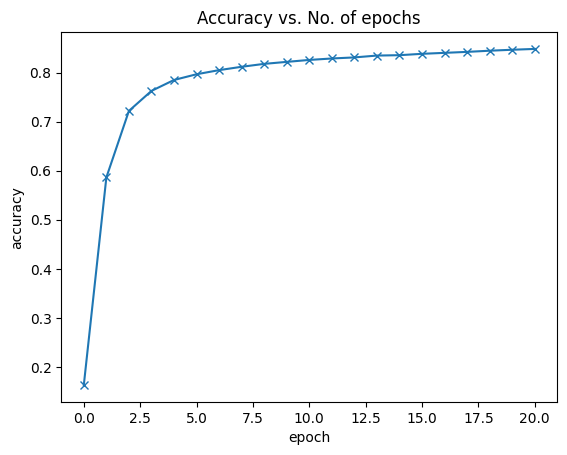

In [54]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc. 

## Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [55]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


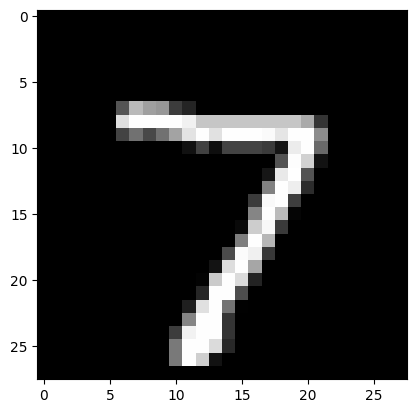

In [56]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [57]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Let's try it out with a few images.

Label: 7 , Predicted: 7


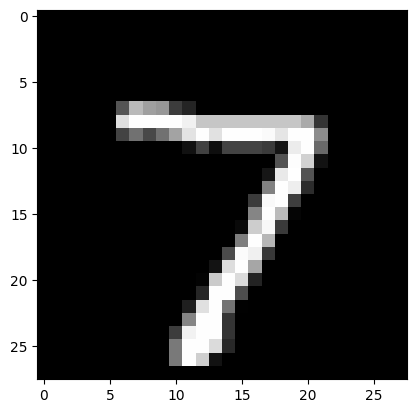

In [58]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


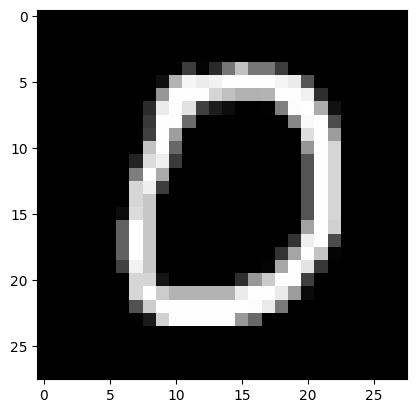

In [59]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 3


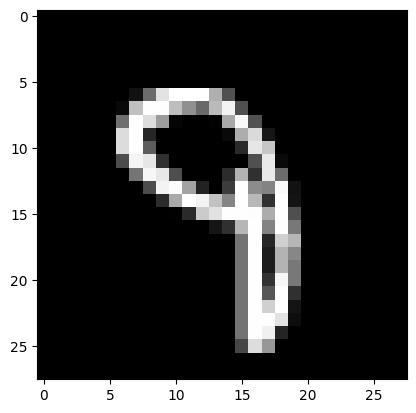

In [60]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


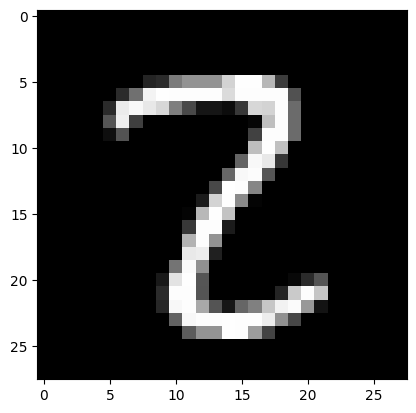

In [61]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [62]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6400398015975952, 'val_acc': 0.8624023199081421}

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [63]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [64]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0196,  0.0330,  0.0273,  ..., -0.0024,  0.0022,  0.0137],
                      [-0.0328,  0.0065, -0.0195,  ...,  0.0217, -0.0345, -0.0350],
                      [-0.0108, -0.0142,  0.0153,  ...,  0.0285, -0.0154,  0.0024],
                      ...,
                      [-0.0103, -0.0294, -0.0192,  ...,  0.0307,  0.0306, -0.0141],
                      [ 0.0273, -0.0156, -0.0260,  ..., -0.0286,  0.0023,  0.0078],
                      [-0.0334, -0.0342,  0.0270,  ..., -0.0052,  0.0074,  0.0156]])),
             ('linear.bias',
              tensor([-0.0439,  0.1266, -0.0101, -0.0293,  0.0414,  0.0111,  0.0061,  0.0542,
                      -0.1262, -0.0099]))])

In [65]:
model2 = MnistModel()

In [66]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0046, -0.0206,  0.0023,  ...,  0.0224, -0.0202,  0.0209],
                      [ 0.0319, -0.0045, -0.0019,  ...,  0.0323, -0.0189,  0.0259],
                      [ 0.0008, -0.0115, -0.0262,  ..., -0.0128,  0.0006,  0.0279],
                      ...,
                      [-0.0330, -0.0323, -0.0288,  ..., -0.0030, -0.0317, -0.0165],
                      [ 0.0279,  0.0308, -0.0206,  ..., -0.0147, -0.0204,  0.0214],
                      [ 0.0015, -0.0049, -0.0146,  ..., -0.0351, -0.0240,  0.0059]])),
             ('linear.bias',
              tensor([-0.0007, -0.0254, -0.0176,  0.0013,  0.0201, -0.0312, -0.0137,  0.0252,
                       0.0034,  0.0127]))])

In [67]:
evaluate(model2, test_loader)

{'val_loss': 2.3160765171051025, 'val_acc': 0.0615234375}

In [68]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0196,  0.0330,  0.0273,  ..., -0.0024,  0.0022,  0.0137],
                      [-0.0328,  0.0065, -0.0195,  ...,  0.0217, -0.0345, -0.0350],
                      [-0.0108, -0.0142,  0.0153,  ...,  0.0285, -0.0154,  0.0024],
                      ...,
                      [-0.0103, -0.0294, -0.0192,  ...,  0.0307,  0.0306, -0.0141],
                      [ 0.0273, -0.0156, -0.0260,  ..., -0.0286,  0.0023,  0.0078],
                      [-0.0334, -0.0342,  0.0270,  ..., -0.0052,  0.0074,  0.0156]])),
             ('linear.bias',
              tensor([-0.0439,  0.1266, -0.0101, -0.0293,  0.0414,  0.0111,  0.0061,  0.0542,
                      -0.1262, -0.0099]))])

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [69]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6400398015975952, 'val_acc': 0.8624023199081421}